Metric learning aims to train models that can embed inputs into a high-dimensional space such that "similar" inputs, as defined by the training scheme, are located close to each other. These models once trained can produce embeddings for downstream systems where such similarity is useful; examples include as a ranking signal for search or as a form of pretrained embedding model for another supervised problem.

In [1]:
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from collections import defaultdict
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

170500096/170498071 [==============================] - 39s 0us/step


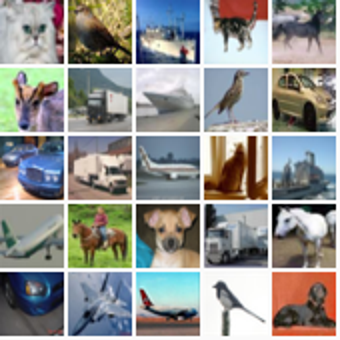

In [4]:
height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode = "RGB",
        size = (num_cols * box_size, num_rows * box_size),
        color = (250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


sample_idxs = np.random.randint(0, 50000, size = (5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

Metric learning provides training data not as explicit (X, y) pairs but instead uses multiple instances that are related in the way we want to express similarity. In our example we will use instances of the same class to represent similarity; a single training instance will not be one image, but a pair of images of the same class. When referring to the images in this pair we'll use the common metric learning names of the anchor (a randomly chosen image) and the positive (another randomly chosen image of the same class).

To facilitate this we need to build a form of lookup that maps from classes to the instances of that class. When generating data for training we will sample from this lookup.

In [5]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

For this example we are using the simplest approach to training; a batch will consist of (anchor, positive) pairs spread across the classes. The goal of learning will be to move the anchor and positive pairs closer together and further away from other instances in the batch. In this case the batch size will be dictated by the number of classes; for CIFAR-10 this is 10.

In [6]:
num_classes = 10


class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype = np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x

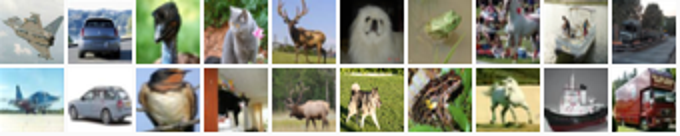

In [7]:
examples = next(iter(AnchorPositivePairs(num_batchs = 1)))

show_collage(examples)

The top row shows randomly chosen anchors from the 10 classes, the bottom row shows the corresponding 10 positives.

In [8]:
class EmbeddingModel(keras.Model):
    def train_step(self, data):
        # Note: Workaround for open issue, to be removed.
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            # Run both anchors and positives through model.
            anchor_embeddings = self(anchors, training = True)
            positive_embeddings = self(positives, training = True)

            # Calculate cosine similarity between anchors and positives. As they have
            # been normalised this is just the pair wise dot products.
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # Since we intend to use these as logits we scale them by a temperature.
            # This value would normally be chosen as a hyper parameter.
            temperature = 0.2
            similarities /= temperature

            # We use these similarities as logits for a softmax. The labels for
            # this call are just the sequence [0, 1, 2, ..., num_classes] since we
            # want the main diagonal values, which correspond to the anchor/positive
            # pairs, to be high. This loss will move embeddings for the
            # anchor/positive pairs together and move all other pairs apart.
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}

In [9]:
inputs = layers.Input(shape = (height_width, height_width, 3))
x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 2, activation = "relu")(inputs)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 2, activation = "relu")(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, activation = "relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units = 8, activation = None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis = -1)

model = EmbeddingModel(inputs, embeddings)
model.summary()

Model: "embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 15, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 3, 128)    73856       conv2d_1[0][0]                   
____________________________________________________________________________________